# Wireless Channel Generation for Outdoor Terrains deployed in Hexagonal Geometry
The channel models has been designed to support the following features:

|Parameters|Values|
| :- | -:  |
| Antenna Array  | [$\text{M}_g, \text{N}_g, \text{M}, \text{N}, \text{P}$]  |
| UE Antenna Array  | [1,1,2,2,1]  |
| UE Antenna  | Omni  |
| BS Antenna Array  | [1,1,4,4,1]  |
| BS Antenna  | Parabolic  |
| Carrier Frequency  | $3 \times 10^9$  |
| Simulation Layout | Rectangular |
| Subcarrier Spacing | 30 kHz|
| fftsize | 512 |
| Terrain | Indoor-Factory (InF-SL) |
| Mobility | Disabled |
| Inter-site Distance | 20 |
| Number of Sectors Site | 3 |
| UE Height | Uniform$(0,1)$ m |
| UE Drop | Random |
| UE Height Distribution | Random |
| BS Height       | 3m  |
| Ceiling Height  | 6m  |
| clutter Height  | 4m  |
| clutter Size    | 3m  |
| clutter Density | 0.4 |


In this Tutorial, we will generate the Multicell MIMO channel between multiple users and multiple base-stations for **Indoor Factory Terrain**. THe content of the tutorial is listed below:

**Table of Contents**

* [Import Libraries](#Import-Libraries)
    - [Python Libraries](#Python-Libraries)
    - [5G Toolkit Libraries](#5G-Toolkit-Libraries)
* [Simulation Parameters](#Simulation-Parameters)
* [Generate Antenna Arrays](#Generate-Antenna-Array)
* [Node Mobility/Route](#Node-Mobility)
* [Generate Simulation Topology](#Generate-Simulation-Layout)
* [Generate Channel(LSP/SSPs) Parameters](#Generate-Channel-Parameters)
* [Generate Channel Coefficients](#Generate-Channel-Coefficients)
* [Generate OFDM Channel Generation](#Generate-OFDM-Channel)
    - [Frequency Domain: Magnitude Response Plot](#Frequency-Domain-:-Magnitude-Response-Plot)
    - [Time Domain Channel Response](#Time-Domain-Channel-response)

## Import Libraries

### Import Python Libraries

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# %matplotlib widget
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy      as np

### Import 5G Toolkit Libraries

In [2]:
import sys
sys.path.append("../../../")

from toolkit5G.ChannelModels import NodeMobility
from toolkit5G.ChannelModels import AntennaArrays
from toolkit5G.ChannelModels import SimulationLayout
from toolkit5G.ChannelModels import ParameterGenerator
from toolkit5G.ChannelModels import ChannelGenerator

## Simulation Parameters

The simulation parameters are defined as follows
  * ``propTerrain`` defines propagation scenario or terrain for BS-UE links
  * ``carrierFrequency`` defines carrier frequency in Hz
  * ``nBSs`` defines number of Base Stations (BSs)
  * ``nUEs`` defines number of User Equipments (UEs) 
  * ``nSnapShots`` defines number of SnapShots

In [3]:
# Simulation Parameters
propTerrain      = "UMa"      # Propagation Scenario or Terrain for BS-UE links
carrierFrequency = 3*10**9                   # carrier frequency in Hz
BSgeometry       = 21           # number of BSs along rows and columns
nBSs             = np.product(BSgeometry)    # number of BSs 
nUEs             = 20                        # number of UEs 
nSnapShots       = 1                         # number of SnapShots

## Generate Antenna Arrays

The following steps describe the procedure to simulate AntennaArrays Objects at a single carrier frequency
both at Tx and Rx side:

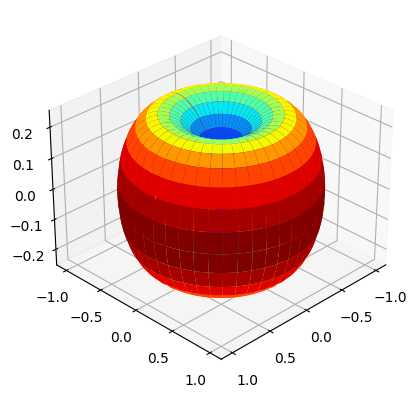

In [4]:
# Antenna Array at UE side
# assuming antenna element type to be "OMNI"
# with 2 panel and 2 single polarized antenna element per panel.

ueAntArray = AntennaArrays(antennaType     = "OMNI", 
                           centerFrequency = carrierFrequency,
                           arrayStructure  = np.array([1,1,2,2,1]))
ueAntArray() 
# Radiation Pattern of Rx antenna element 
fig, ax = ueAntArray.displayAntennaRadiationPattern()

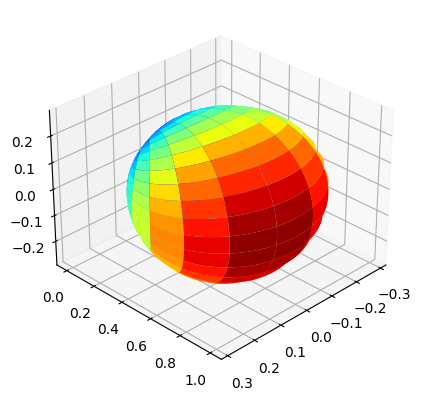

In [5]:
# Antenna Array at BS side
# assuming antenna element type to be "3GPP_38.901", a parabolic antenna 
# with 4 panel and 4 single polarized antenna element per panel.


bsAntArray = AntennaArrays(antennaType     = "3GPP_38.901", 
                           centerFrequency = carrierFrequency,
                           arrayStructure  = np.array([1,1,4,4,1]))
bsAntArray()
# Radiation Pattern of Tx antenna element 
fig, ax = bsAntArray.displayAntennaRadiationPattern()

## Generate Simulation Layout

We define the simulation topology parametes:

 - ``ISD``: Inter Site Distance
 - ``minDist``: Minimum distance between transmitter and receiver.
 - ``bsHt``: BS heights 
 - ``ueHt``: UE heights
 - ``topology``: Simulation Topology
 - ``nSectorsPerSite``: Number of Sectors Per Site
 
Furthermore, users can access and update following parameters as per their requirements for channel using the handle simLayoutObj.x where x is:

 - The following parameters can be accessed or updated immendiately after object creation
    - ``UEtracks``
    - ``UELocations``
    - ``ueOrientation``
    - ``UEvelocityVector``
    - ``BStracks``
    - ``BSLocations``
    - ``bsOrientation``
    - ``BSvelocityVector``
    
 - The following parameters can be accessed or updated after calling the object
    - ``linkStateVec``
    

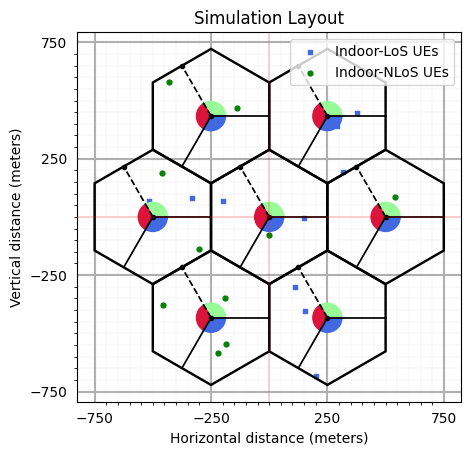

In [6]:
# Layout Parameters
isd                  = 500         # inter site distance in meters
minDist              = 10           # min distance between each UE and BS in meters
ueHt                 = 1           # UE height in meters
ceilingHt            = 6           # height of ceiling in meters
clutterHt            = 4           # height of clutter for indoor factory scenario
clutterSize          = 3           # size of clutter for indoor factory scenario
clutterDen           = 0.4         # density of clutter for indoor factory scenario
bsHt                 = 3           # BS height in meters
bslayoutType         = "Hexagonal" # BS layout type
ueDropType           = "Hexagonal" # UE drop type
nSectorsPerSite      = 3           # number of sectors per site
indoorUEfract        = 1           # Fraction of UEs located indoor
htDist               = "random"    # UE height distribution
ueDist               = "random"    # UE Distribution per site
lengthOfIndoorObject = 3           # length of indoor object typically having rectangular geometry 
widthOfIndoorObject  = 3           # width of indoor object


simLayoutObj = SimulationLayout(numOfBS = BSgeometry,
                                numOfUE = nUEs,
                                heightOfBS = bsHt,
                                heightOfUE = ueHt, 
                                ISD = isd,
                                layoutType = bslayoutType,
                                ueDropMethod = ueDropType, 
                                UEdistibution = ueDist,
                                UEheightDistribution = htDist,
                                numOfSectorsPerSite = nSectorsPerSite,
                                minUEBSDistance = minDist)
simLayoutObj(terrain = propTerrain, 
             carrierFreq = carrierFrequency,
             ueAntennaArray = ueAntArray,
             bsAntennaArray = bsAntArray,                 
             indoorUEfraction = indoorUEfract,
             heightOfRoom = ceilingHt,
             clutterHeight = clutterHt,
             clutterSize = clutterSize, 
             clutterDensity = clutterDen)
# displaying the topology of simulation layout
fig, ax = simLayoutObj.display2DTopology()
ax.set_xlabel("x-coordinates (m)")
ax.set_ylabel("y-coordinates (m)")
ax.set_title("Simulation Topology")
ax.legend()

## Generate Channel Parameters

* This subsection provides the steps to obtain all the cluster level channel parameters, which includes both `Large Scale Parameters (LSPs)`
  and `Small Scale Parameters (SSPs)`. 
* LSPs includes `Path Loss (PL)`, `Delay Spread (DS)` and `Angular Spreads` both in Azimuth and Zenith directions,
  and `cluster powers (Pn)` comes under SSPs.
  
- LSPs/SSPs: paramGenObj.x where x is
    - ``linkStateVec``
    - ``delaySpread``
    - ``phiAoA_LoS``, ``phiAoA_mn``, ``phiAoA_spread``
    - ``thetaAoA_LoS``, ``thetaAoA_mn``, ``thetaAoA_spread``
    - ``phiAoD_LoS``, ``phiAoD_mn``, ``phiAoD_spread``
    - ``thetaAoD_LoS``, ``thetaAoD_mn``, ``thetaAoD_spread``
    - ``xpr``
    - ``pathloss``, ``pathDelay``, ``pathPower``
    - ``shadowFading``

In [7]:
# channel parameters
paramGenObj = simLayoutObj.getParameterGenerator()

[Warning]: Pathloss model for UMa is defined only for BS height 'hBS' = 25! Ignoring for now but might results in unexpected behaviour!
[Warning]: Pathloss model for UMa is defined only for BS height 'hBS' = 25! Ignoring for now but might results in unexpected behaviour!


## Generate Channel Coefficients

Cluster level channel coefficients can be simulated using the following code snippet.

 - ``channel.coefficients`` with shape: `(number of carrier frequencies, number of snapshots, number of BSs, number of UEs, numCluster/numPaths, number of Rx antennas, number of Tx antennas)`
 - ``channel.delays`` with shape: `(number of carrier frequencies, number of snapshots, number of BSs, number of UEs, numCluster/numPaths)`


In [8]:
channel = paramGenObj.getChannel(applyPathLoss = True)
channel.coefficients.shape

(1, 1, 21, 20, 24, 4, 16)

## Generate OFDM Channel

- Shape of OFDM Channel:
    - `Hf` is of shape : ``(number of carrier frequencies, number of snapshots, number of BSs, number of UEs, fftsize, number of Rx antennas, number of Tx antennas)``

In [9]:
fftsize           = 1024
subcarrierSpacing = 30*10**3
Hf = channel.ofdm(subcarrierSpacing, fftsize, simLayoutObj.carrierFrequency)
Hf.shape

(1, 1, 21, 20, 1024, 4, 16)

### Frequency Domain : Magnitude Response Plot

* The frequency domain magnitude plots (frequency responses) helps demonstate the order of frequency selectivity
    - Frequency selectivity is low for LOS Channel
    - frequency selectivity is high for NLOS Channels
    
* Wireless channel at high frequency
    - has higher path-loss
    - less frequency selective (due to lower delay spread and weak distance paths)
    


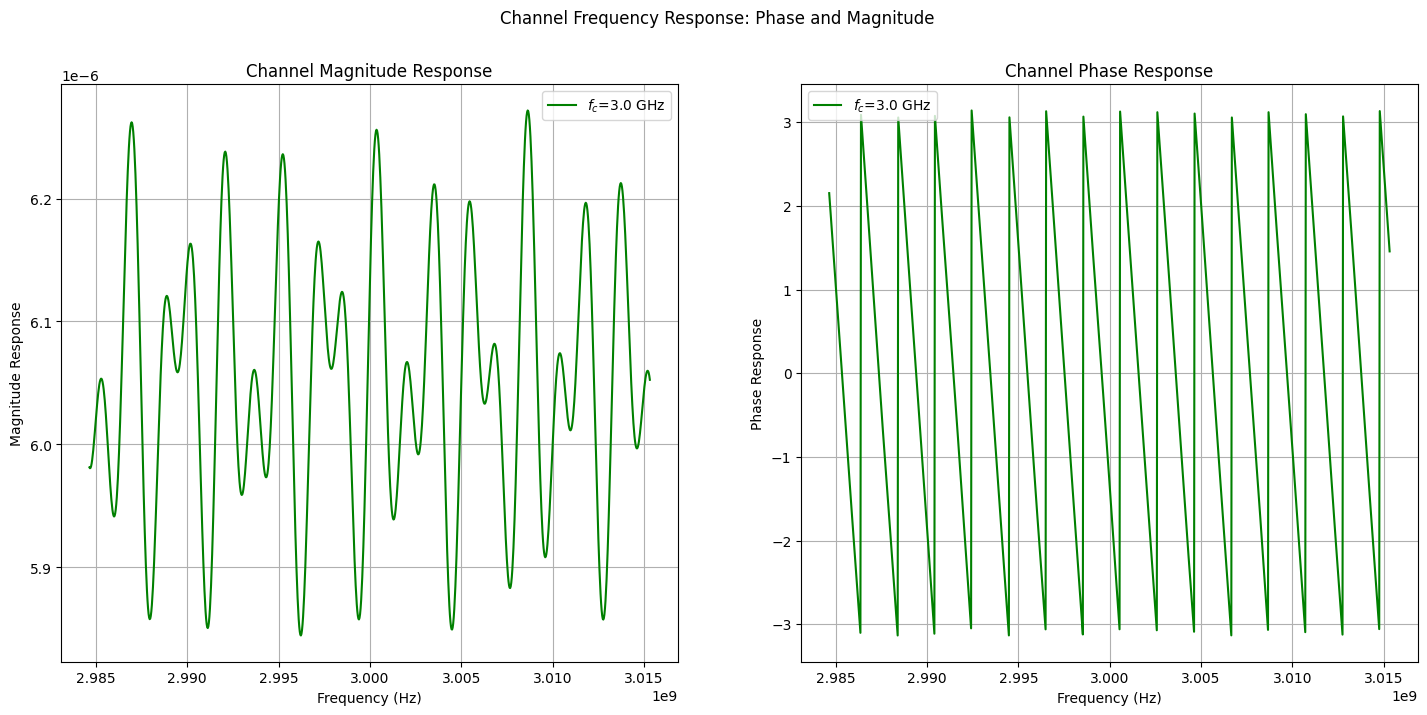

In [10]:
scaleFig = 1
fig, ax = plt.subplots(1, 2, figsize=(17.5/scaleFig,7.5/scaleFig))

i = 0
ax[0].plot(np.arange(-channel.fftSize/2, channel.fftSize/2)*channel.subCarrierSpacing + channel.fc[0], 
           np.abs(Hf[0,0,0,i,:,0,0]), "g", label = "$f_c$="+str(channel.fc[0]/10**9)+" GHz")


ax[0].legend()
ax[0].set_xlabel("Frequency (Hz)")
ax[0].set_ylabel("Magnitude Response")
ax[0].set_title("Channel Magnitude Response")
ax[0].grid()

ax[1].plot(np.arange(-channel.fftSize/2, channel.fftSize/2)*channel.subCarrierSpacing + channel.fc[0], 
           np.angle(Hf[0,0,0,i,:,0,0]), "g", label = "$f_c$="+str(channel.fc[0]/10**9)+" GHz")


ax[1].legend()
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_ylabel("Phase Response")
ax[1].grid()
ax[1].set_title("Channel Phase Response")

fig.suptitle("Channel Frequency Response: Phase and Magnitude")

plt.show()

### Time Domain Channel response

- Practical wireless channel are bandlimited which results in:
    - impulses widening:
        - higher for lower frequency channels
    - time spread
    
These effects can be observed in following plots.

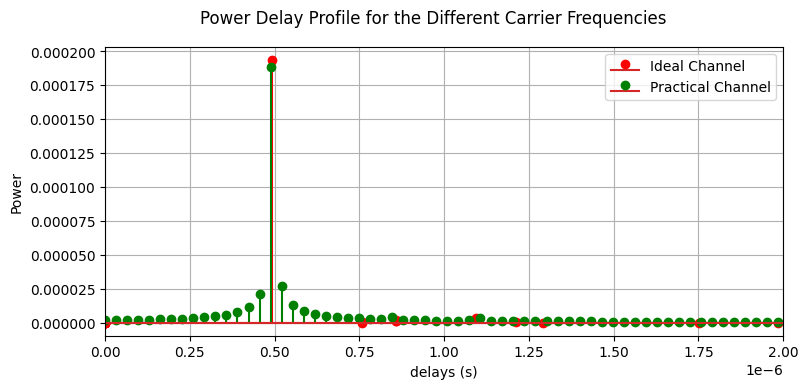

In [11]:
ht = np.fft.ifft(Hf, fftsize, axis = -3, norm = "ortho")

scaleFig = 2
fig, ax = plt.subplots(figsize=(17.5/scaleFig,7.5/scaleFig))
i = 0
ax.stem(channel.delays[0,0,0,i], np.abs(channel.coefficients[0,0,0,i,:,0,0]), "r", label = "Ideal Channel")
ax.stem(np.arange(channel.fftSize)/(channel.fftSize*channel.subCarrierSpacing), np.abs(ht[0,0,0,i,:,0,0]), "g", label = "Practical Channel")
ax.legend()
ax.set_xlim([0, 0.2*10**-5])
ax.set_xlabel("delays (s)")
ax.set_ylabel("Power")
ax.grid()


fig.suptitle("Power Delay Profile for the Different Carrier Frequencies")
plt.show()